# 리텐션 분석

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize_matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.2 MB/s eta 0:00:00


In [7]:
path = '/content/drive/MyDrive/새싹2기/python_DA/data/'

In [8]:
events = pd.read_csv(path + 'rocket_sample_events.csv')

In [9]:
events.tail(2)

,user_id,event_name,event_date,timestamp,platform,amount
20981,rk_2000,view_item,2024-06-21,2024-06-21 14:56:00.000000000,Web,NaN
20982,rk_2000,add_to_cart,2024-06-21,2024-06-21 14:53:00.000000000,Web,NaN


In [10]:
events.dtypes

,0
user_id,object
event_name,object
event_date,object
timestamp,object
platform,object
amount,float64


In [12]:
events['event_date'] = pd.to_datetime(events['event_date'])

In [14]:
events.dtypes

,0
user_id,object
event_name,object
event_date,datetime64[ns]
timestamp,object
platform,object
amount,float64


In [15]:
events.shape

(20983, 6)

In [16]:
events['user_id'].nunique()

2000

## (1) 유저별 첫 방문일 산정

In [17]:
first_visit = (
    events[events['event_name'] == 'visit'].
    groupby('user_id')['event_date'].min()
    .reset_index()
    )
first_visit.columns = ['user_id', 'first_date']

In [20]:
events[events['event_name'] == 'visit'].head()

,user_id,event_name,event_date,timestamp,platform,amount
0,rk_0001,visit,2024-01-30,2024-01-30 17:52:00.000000000,Android,NaN
3,rk_0001,visit,2024-01-10,2024-01-10 16:24:00.000000000,Android,NaN
6,rk_0001,visit,2024-01-25,2024-01-25 19:47:00.000000000,Android,NaN
9,rk_0001,visit,2024-06-20,2024-06-20 13:41:00.000000000,Android,NaN
11,rk_0002,visit,2024-02-13,2024-02-13 09:15:06.723361680,iOS,NaN


## (2) 데이터 병합

In [21]:
df = events.merge(first_visit, on='user_id')
df['days_since'] = (df['event_date'] - df['first_date']).dt.days

In [23]:
df.head(10)

,user_id,event_name,event_date,timestamp,platform,amount,first_date,days_since
0,rk_0001,visit,2024-01-30,2024-01-30 17:52:00.000000000,Android,NaN,2024-01-10,20
1,rk_0001,view_item,2024-01-30,2024-01-30 17:52:00.000000000,Android,NaN,2024-01-10,20
2,rk_0001,add_to_cart,2024-01-30,2024-01-30 17:51:00.000000000,Android,NaN,2024-01-10,20
3,rk_0001,visit,2024-01-10,2024-01-10 16:24:00.000000000,Android,NaN,2024-01-10,0
4,rk_0001,view_item,2024-01-10,2024-01-10 16:20:00.000000000,Android,NaN,2024-01-10,0
5,rk_0001,add_to_cart,2024-01-10,2024-01-10 16:20:00.000000000,Android,NaN,2024-01-10,0
6,rk_0001,visit,2024-01-25,2024-01-25 19:47:00.000000000,Android,NaN,2024-01-10,15
7,rk_0001,view_item,2024-01-25,2024-01-25 19:49:00.000000000,Android,NaN,2024-01-10,15
8,rk_0001,add_to_cart,2024-01-25,2024-01-25 19:50:00.000000000,Android,NaN,2024-01-10,15
9,rk_0001,visit,2024-06-20,2024-06-20 13:41:00.000000000,Android,NaN,2024-01-10,162


<Axes: xlabel='days_since', ylabel='Density'>

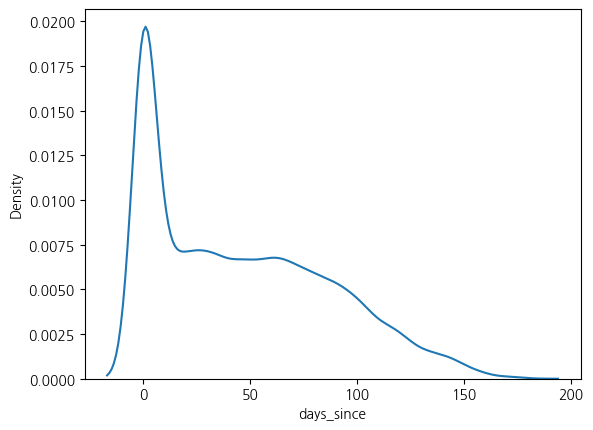

In [25]:
sns.kdeplot(df['days_since'])

In [34]:
total_users = 2000

In [31]:
d7 = df[df['days_since']== 2]['user_id'].nunique()
d7

63

In [35]:
d7_rate = d7/ total_users
d7_rate

0.0315

In [36]:
df['event_date'].min(), df['event_date'].max()

(Timestamp('2024-01-02 00:00:00'), Timestamp('2024-06-29 00:00:00'))

### D7 기준 Rolling Retention

In [38]:
# === visit 기준 D7 리텐션 ===
visit_d7 = df[df['days_since'] == 7]['user_id'].nunique()
visit_d7_rate = visit_d7 / total_users * 100

# === purchase 기준 D7 리텐션 ===
# 1. 구매 경험이 있는 사용자의 첫 구매일 계산
first_purchase = (
    events[events['event_name'] == 'purchase']
    .groupby('user_id')['event_date'].min()
    .reset_index()
)
first_purchase.columns = ['user_id', 'first_purchase_date']

# 2. 구매 이벤트에 첫 구매일 병합 + 경과 일수 계산
purchase_events = events[events['event_name'] == 'purchase'].merge(first_purchase, on='user_id')
purchase_events['days_since_purchase'] = (purchase_events['event_date'] - purchase_events['first_purchase_date']).dt.days

# 3. purchase 기준 D7 계산
purchase_total = first_purchase['user_id'].nunique()
purchase_d7 = purchase_events[purchase_events['days_since_purchase'] == 7]['user_id'].nunique()
purchase_d7_rate = purchase_d7 / purchase_total * 100

print(f"visit   기준 D7 Classic: {visit_d7_rate:.1f}%  ({visit_d7:,}/{total_users:,}명)")
print(f"purchase 기준 D7 Classic: {purchase_d7_rate:.1f}%  ({purchase_d7:,}/{purchase_total:,}명)")

visit   기준 D7 Classic: 2.8%  (56/2,000명)
purchase 기준 D7 Classic: 0.0%  (0/478명)


### Classic Retention

In [39]:
# Classic 리텐션: 정확히 N일째에 활동한 고유 사용자 수
classic_active = (
    df[df['days_since'] >= 0]
    .groupby('days_since')['user_id']
    .nunique()
    .reset_index()
)
classic_active.columns = ['day', 'active_users']
classic_active['classic_rate'] = (classic_active['active_users'] / total_users * 100).round(1)

print("[Classic 리텐션 (처음 14일)]")
print(classic_active[classic_active['day'] <= 14].to_string(index=False))

[Classic 리텐션 (처음 14일)]
 day  active_users  classic_rate
   0          2000         100.0
   1            74           3.7
   2            63           3.2
   3            66           3.3
   4            75           3.8
   5            59           2.9
   6            63           3.2
   7            56           2.8
   8            45           2.2
   9            63           3.2
  10            71           3.6
  11            68           3.4
  12            58           2.9
  13            58           2.9
  14            64           3.2


### Rolling Retention

In [40]:
# 사용자별 마지막 활동일 (경과 일수 기준)
user_last_day = df.groupby('user_id')['days_since'].max().reset_index()
user_last_day.columns = ['user_id', 'last_day']

# Rolling 리텐션: 마지막 활동일 >= N일인 사용자 비율
max_day = 30
rolling_data = []

for n in range(0, max_day + 1):
    still_active = (user_last_day['last_day'] >= n).sum()
    rolling_data.append({
        'day': n,
        'still_active': still_active,
        'rolling_rate': round(still_active / total_users * 100, 1)
    })

rolling_active = pd.DataFrame(rolling_data)

print("[Rolling 리텐션 (처음 14일)]")
print(rolling_active[rolling_active['day'] <= 14].to_string(index=False))

[Rolling 리텐션 (처음 14일)]
 day  still_active  rolling_rate
   0          2000         100.0
   1          1745          87.2
   2          1742          87.1
   3          1737          86.9
   4          1732          86.6
   5          1728          86.4
   6          1726          86.3
   7          1723          86.2
   8          1720          86.0
   9          1718          85.9
  10          1713          85.6
  11          1709          85.4
  12          1706          85.3
  13          1701          85.0
  14          1698          84.9


### 두 방식 비교

In [41]:
# Classic + Rolling 합치기
compare = classic_active[classic_active['day'] <= 30][['day', 'classic_rate']].merge(
    rolling_active[['day', 'rolling_rate']], on='day'
)
compare['gap'] = (compare['rolling_rate'] - compare['classic_rate']).round(1)

print("[Classic vs Rolling 비교]")
print(compare[compare['day'].isin([0, 1, 3, 7, 14, 21, 30])].to_string(index=False))

[Classic vs Rolling 비교]
 day  classic_rate  rolling_rate  gap
   0         100.0         100.0  0.0
   1           3.7          87.2 83.5
   3           3.3          86.9 83.6
   7           2.8          86.2 83.4
  14           3.2          84.9 81.7
  21           3.4          82.6 79.2
  30           3.8          80.1 76.3


## (3) 데이터 시각화

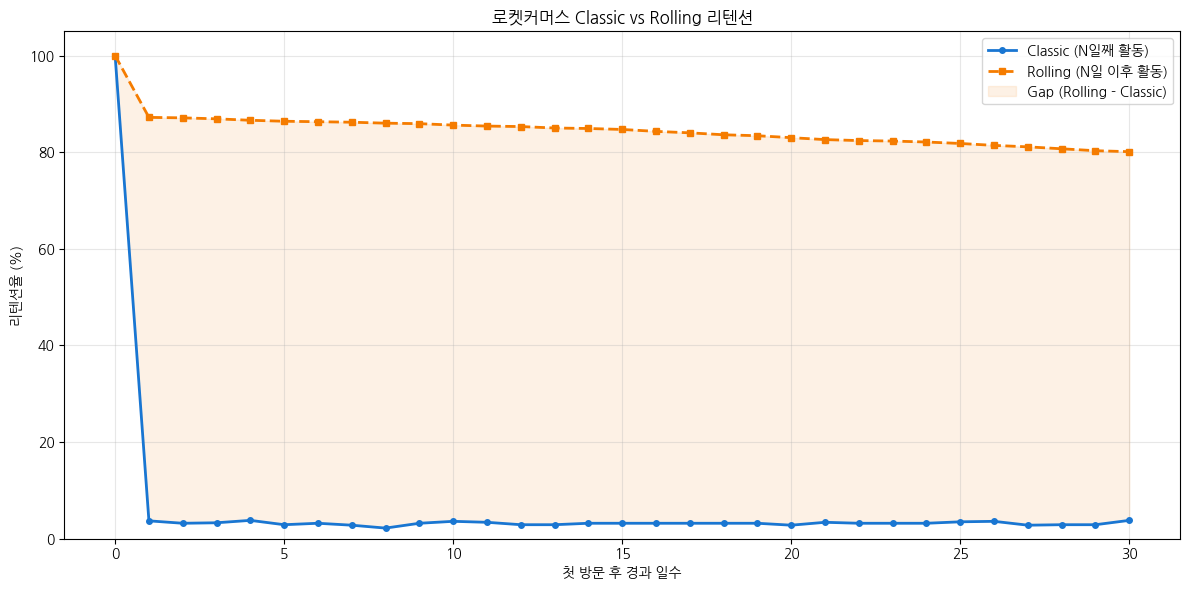

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_classic = classic_active[classic_active['day'] <= 30]
plot_rolling = rolling_active[rolling_active['day'] <= 30]

ax.plot(plot_classic['day'], plot_classic['classic_rate'],
        marker='o', color='#1976D2', linewidth=2, markersize=4, label='Classic (N일째 활동)')
ax.plot(plot_rolling['day'], plot_rolling['rolling_rate'],
        marker='s', color='#F57C00', linewidth=2, markersize=4, label='Rolling (N일 이후 활동)', linestyle='--')

ax.fill_between(plot_classic['day'],
                plot_classic['classic_rate'].values,
                plot_rolling['rolling_rate'].values,
                alpha=0.1, color='#F57C00', label='Gap (Rolling - Classic)')

ax.set_xlabel('첫 방문 후 경과 일수')
ax.set_ylabel('리텐션율 (%)')
ax.set_title('로켓커머스 Classic vs Rolling 리텐션')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

💡차트 읽는 법
- 파란 실선(Classic): 정확히 그 날 돌아온 사용자 → 일별 변동이 있음
- 주황 점선(Rolling): 그 날 이후에도 남아있는 사용자 → 항상 Classic보다 위
- 주황 영역(Gap): 두 방식의 차이 → Gap이 클수록 "간헐적 사용자"가 많다는

In [43]:
plot_classic = plot_classic.copy()
plot_classic['drop'] = plot_classic['classic_rate'].diff()

print("[Classic 리텐션 급락 Top 5 (전일 대비)]")
top_drops = plot_classic.nsmallest(5, 'drop')[['day', 'classic_rate', 'drop']]
print(top_drops.to_string(index=False))

[Classic 리텐션 급락 Top 5 (전일 대비)]
 day  classic_rate  drop
   1           3.7 -96.3
   5           2.9  -0.9
  27           2.8  -0.8
   8           2.2  -0.6
   2           3.2  -0.5


In [44]:
plot_classic = plot_classic.copy()
plot_classic['drop'] = plot_classic['classic_rate'].diff()

print("[Classic 리텐션 급락 Top 5 (전일 대비)]")
top_drops = plot_classic.nsmallest(5, 'drop')[['day', 'classic_rate', 'drop']]
print(top_drops.to_string(index=False))

[Classic 리텐션 급락 Top 5 (전일 대비)]
 day  classic_rate  drop
   1           3.7 -96.3
   5           2.9  -0.9
  27           2.8  -0.8
   8           2.2  -0.6
   2           3.2  -0.5


In [45]:
# 경과 주(week) 계산
df['weeks_since'] = df['days_since'] // 7

# 주간 Classic 리텐션
weekly_active = (
    df[df['weeks_since'] >= 0]
    .groupby('weeks_since')['user_id']
    .nunique()
    .reset_index()
)
weekly_active.columns = ['week', 'active_users']
weekly_active['retention_rate'] = (weekly_active['active_users'] / total_users * 100).round(1)

print("[주간 Classic 리텐션]")
print(weekly_active[weekly_active['week'] <= 12].to_string(index=False))

[주간 Classic 리텐션]
 week  active_users  retention_rate
    0          2000           100.0
    1           379            19.0
    2           398            19.9
    3           413            20.6
    4           396            19.8
    5           372            18.6
    6           402            20.1
    7           359            18.0
    8           383            19.2
    9           385            19.2
   10           347            17.3
   11           337            16.8
   12           297            14.8


In [47]:
# 사용자별 주요 플랫폼 (가장 많이 사용한 플랫폼)
user_platform = (
    events.groupby('user_id')['platform']
    .agg(lambda x: x.value_counts().index[0])
    .reset_index()
)
user_platform.columns = ['user_id', 'main_platform']

# 플랫폼 정보 병합
df_with_platform = df.merge(user_platform, on='user_id')

print("[플랫폼별 D7 리텐션 (Classic)]")
for p in ['iOS', 'Android', 'Web']:
    p_users = df_with_platform[df_with_platform['main_platform'] == p]['user_id'].nunique()
    p_d7 = df_with_platform[
        (df_with_platform['main_platform'] == p) &
        (df_with_platform['days_since'] == 7)
    ]['user_id'].nunique()
    rate = p_d7 / p_users * 100 if p_users > 0 else 0
    print(f"  {p:10s}: {p_users:,}명 중 {p_d7:,}명 재방문 → D7 Classic {rate:.1f}%")

[플랫폼별 D7 리텐션 (Classic)]
  iOS       : 830명 중 25명 재방문 → D7 Classic 3.0%
  Android   : 704명 중 13명 재방문 → D7 Classic 1.8%
  Web       : 466명 중 18명 재방문 → D7 Classic 3.9%


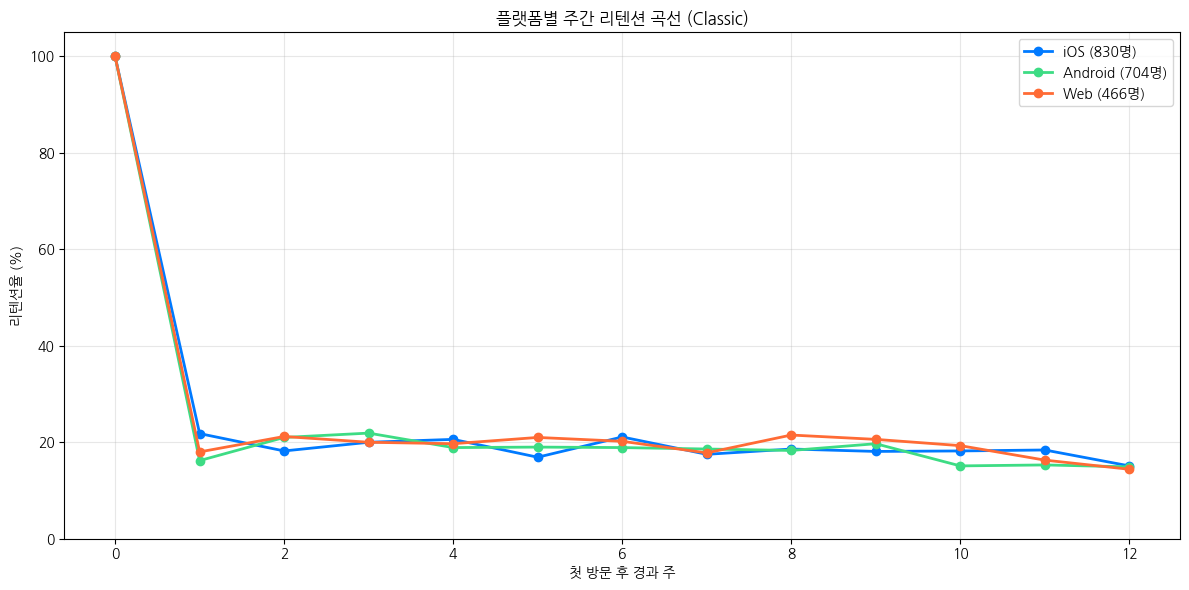

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'iOS': '#007AFF', 'Android': '#3DDC84', 'Web': '#FF6B35'}

for p in ['iOS', 'Android', 'Web']:
    p_df = df_with_platform[df_with_platform['main_platform'] == p]
    p_total = p_df['user_id'].nunique()

    p_weekly = (
        p_df[p_df['weeks_since'] >= 0]
        .groupby('weeks_since')['user_id']
        .nunique()
        .reset_index()
    )
    p_weekly.columns = ['week', 'active_users']
    p_weekly['retention_rate'] = (p_weekly['active_users'] / p_total * 100).round(1)
    p_weekly = p_weekly[p_weekly['week'] <= 12]

    ax.plot(p_weekly['week'], p_weekly['retention_rate'],
            marker='o', label=f'{p} ({p_total:,}명)', color=colors[p], linewidth=2)

ax.set_xlabel('첫 방문 후 경과 주')
ax.set_ylabel('리텐션율 (%)')
ax.set_title('플랫폼별 주간 리텐션 곡선 (Classic)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

# 실습
## 상황: 새벽마켓 — 프리미엄 식품을 새벽에 배송해주는 서비스
- 타겟: 1~2인 가구, 요리에 관심 있지만 시간이 없는 30대
- 핵심 가치: "오늘 밤 주문하면, 내일 아침 신선한 식재료가 문 앞에"

어느 날 PM이 데이터팀에 다음과 같은 요청을 보냅니다.
>"신규 가입자가 계속 늘고 있는데, MAU 성장이 둔화되고 있어요.
리텐션에 문제가 있는 것 같은데, 정확히 어디가 문제인지 파악해주세요."

In [52]:
behavior = pd.read_csv(path + 'saebyek_user_behavior.csv')
raw = pd.read_csv(path + 'saebyek_retention_data.csv')

In [53]:
raw['timestamp'] = pd.to_datetime(raw['timestamp'])
raw['cohort_start'] = pd.to_datetime(raw['cohort'] + '-01')
raw['week'] = ((raw['timestamp'] - raw['cohort_start']).dt.days // 7).clip(lower=0)

cohort_sizes = {'2024-01': 5200, '2024-02': 6800, '2024-03': 8500}

weekly = raw.groupby(['cohort', 'week'])['user_id'].nunique().reset_index()
weekly.columns = ['cohort', 'week', 'active_users']
weekly['cohort_size'] = weekly['cohort'].map(cohort_sizes)
weekly['retention_rate'] = (weekly['active_users'] / weekly['cohort_size'] * 100).round(1)

pivot = weekly.pivot(index='cohort', columns='week', values='retention_rate')
print(pivot)

week         0     1     2     3     4
cohort                                
2024-01  100.0  32.0  18.0  14.0  12.0
2024-02  100.0  28.0  15.0  11.0   9.0
2024-03  100.0  25.0  12.0   NaN   NaN


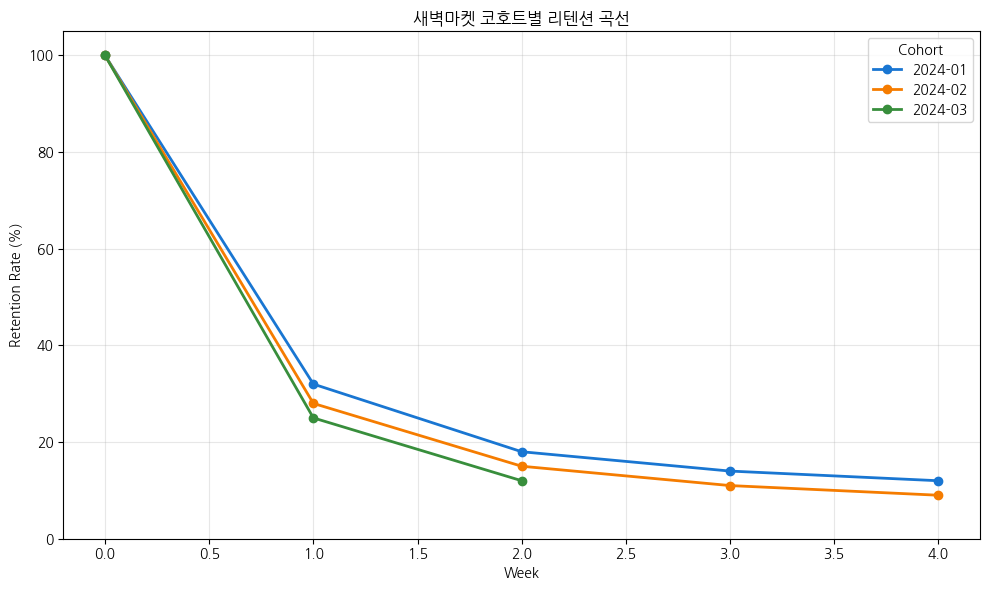

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'2024-01': '#1976D2', '2024-02': '#F57C00', '2024-03': '#388E3C'}
for cohort in ['2024-01', '2024-02', '2024-03']:
    data = weekly[weekly['cohort'] == cohort]
    ax.plot(data['week'], data['retention_rate'],
            marker='o', label=cohort, color=colors[cohort], linewidth=2)

ax.set_xlabel('Week')
ax.set_ylabel('Retention Rate (%)')
ax.set_title('새벽마켓 코호트별 리텐션 곡선')
ax.legend(title='Cohort')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

In [55]:
# 보고서 핵심 수치 검증
print("=== 1. 현황 ===")
print(f"가입자 성장: 5,200 → 8,500 ({(8500-5200)/5200*100:.0f}% 증가)")
print(f"W1 리텐션: 32% → 28% → 25% (하락 추세)")
print()

print("=== 2. 핵심 문제 ===")
for cohort, w1 in [('1월', 32), ('2월', 28), ('3월', 25)]:
    print(f"  {cohort} W0→W1 급락: -{100-w1}%p")
print()

print("=== 3. 아하 모먼트 ===")
print(f"첫 주문 완료: 리테인 88% vs 이탈 31% → 차이 +57%p")
print(f"즐겨찾기 3+: 리테인 64% vs 이탈 15% → 차이 +49%p")

=== 1. 현황 ===
가입자 성장: 5,200 → 8,500 (63% 증가)
W1 리텐션: 32% → 28% → 25% (하락 추세)

=== 2. 핵심 문제 ===
  1월 W0→W1 급락: -68%p
  2월 W0→W1 급락: -72%p
  3월 W0→W1 급락: -75%p

=== 3. 아하 모먼트 ===
첫 주문 완료: 리테인 88% vs 이탈 31% → 차이 +57%p
즐겨찾기 3+: 리테인 64% vs 이탈 15% → 차이 +49%p
